# Final Project - Artificial Intelligence - 2020.1

Name: Luiz Felipe Raveduti Zafiro </br>
Ra: 120513 </br>
</br>
Compuer Engineering - Federal University of São Paulo - Unifesp </br> </br>
Project of a classifier for Intel Image Classification Dataset </br>
In this project we are gonna implement and compare 3 techniques of Supervised AI: </br>


1.   Multilayer Perceptron
2.   Convolutional Neural Network
3.   Suport Vector Machine !

## Imports

In [82]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import pickle
import seaborn as sn
from tqdm import tqdm
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
from kerastuner.tuners import RandomSearch
from sklearn.metrics import confusion_matrix

## DataSet Load and Exploration

In [83]:
# 0 = training
# 1 = test
# 2 = prediction 
data_set_paths = ['./Intel-Image-Classification/seg_train',
                  './Intel-Image-Classification/seg_test',
                  './Intel-Image-Classification/seg_pred'
                  ]

# The indexes of each label in this list corresponds to the numerical label
label_enum = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Size of the image
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

In [84]:
# As data set is large to load in RAM, we will load it from batches of size 32
def preprocessing_func(img):
    image = np.array(img)
    return image / 255
    
datagen = ImageDataGenerator(preprocessing_function=preprocessing_func)

# Generates the data set batches
train_it = datagen.flow_from_directory(data_set_paths[0], 
                                       class_mode='binary', 
                                       target_size=IMAGE_SIZE, 
                                       batch_size=BATCH_SIZE,
                                       shuffle=True
                                      )

test_it = datagen.flow_from_directory(data_set_paths[1], 
                                      class_mode='binary', 
                                      target_size=IMAGE_SIZE, 
                                      batch_size=BATCH_SIZE,
                                      shuffle=False
                                     )

batchX, batchy = train_it.next()
print('Batch shape={}, min_value={:.2f}, max_value={:.2f}'.format(batchX.shape, batchX.min(), batchX.max()))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Batch shape=(32, 150, 150, 3), min_value=0.00, max_value=1.00


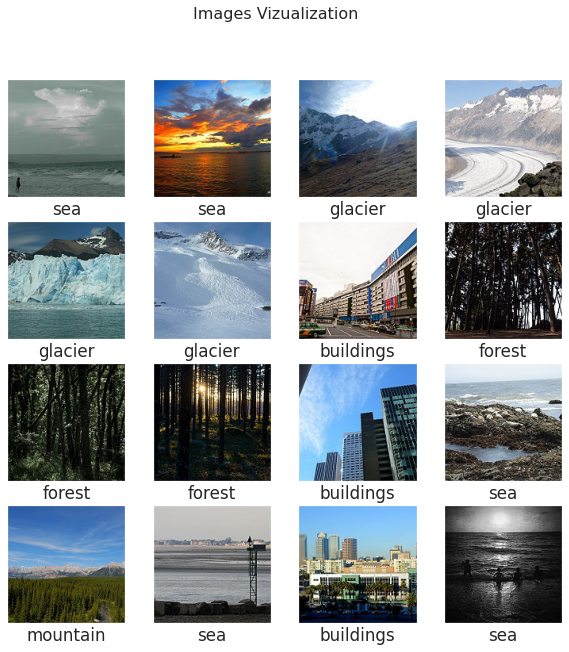

In [85]:
# Gets the index of the number one founded in the array
# used to get the correct class
def indexOfOne(arr): 
    # traverse the array from left to right 
    for i in range(0, len(arr)): 
        # if true, then return i 
        if (arr[i] == 1): 
            return i 

# Show 16 images for visualization
def imgVisualization(imgs, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Images Vizualization", fontsize=16)
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(imgs[i], cmap=plt.cm.binary)
        plt.xlabel(label_enum[int(labels[i])])
    plt.show()

# Visualizing 16 images of a random batch    
batchX, batchy = train_it.next()
imgVisualization(batchX, batchy)

# Convolutional Neural Network

### Model Specification and Training

In [86]:
# Model Creation
model = tf.keras.Sequential()
    
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(6,activation='softmax'))

# Compile Model
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )

In [87]:
# Fitting model
history = model.fit_generator(train_it, 
                    steps_per_epoch=14034//BATCH_SIZE,
                    validation_data=test_it, 
                    validation_steps=3000//BATCH_SIZE,
                    epochs=10,
                    verbose=2)

Epoch 1/10
438/438 - 20s - loss: 1.1347 - accuracy: 0.5630 - val_loss: 1.0357 - val_accuracy: 0.6274
Epoch 2/10
438/438 - 19s - loss: 0.7736 - accuracy: 0.7328 - val_loss: 0.7946 - val_accuracy: 0.7147
Epoch 3/10
438/438 - 19s - loss: 0.5397 - accuracy: 0.8184 - val_loss: 0.6557 - val_accuracy: 0.7826
Epoch 4/10
438/438 - 19s - loss: 0.3626 - accuracy: 0.8814 - val_loss: 0.7208 - val_accuracy: 0.7789
Epoch 5/10
438/438 - 19s - loss: 0.2308 - accuracy: 0.9278 - val_loss: 1.0331 - val_accuracy: 0.7624
Epoch 6/10
438/438 - 19s - loss: 0.1612 - accuracy: 0.9562 - val_loss: 1.0447 - val_accuracy: 0.7708
Epoch 7/10
438/438 - 19s - loss: 0.1024 - accuracy: 0.9710 - val_loss: 1.2566 - val_accuracy: 0.7661
Epoch 8/10
438/438 - 19s - loss: 0.0848 - accuracy: 0.9792 - val_loss: 1.3306 - val_accuracy: 0.7668
Epoch 9/10
438/438 - 19s - loss: 0.0605 - accuracy: 0.9847 - val_loss: 1.3337 - val_accuracy: 0.7655
Epoch 10/10
438/438 - 19s - loss: 0.0706 - accuracy: 0.9812 - val_loss: 1.8162 - val_accura

### Model History Evaluation

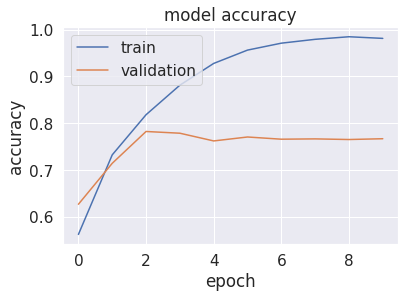

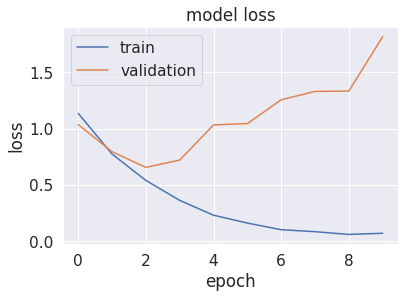

In [88]:
def plot_hist(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

### Saving Model Information

In [89]:
# Save history
!mkdir -p train_history
with open('./train_history/cnn.pickle','wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [90]:
# Save Model for future use
!mkdir -p saved_model
model.save('saved_model/cnn_model')

# Shows model specifications
model.summary()

INFO:tensorflow:Assets written to: saved_model/cnn_model/assets
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               10617088  
________________________________________________________

### Load Trained Model

In [91]:
# If it has already beeeing trainned
model = tf.keras.models.load_model('saved_model/cnn_model')

### Model Evaluation

In [92]:
# evaluate model
model.evaluate(test_it, steps=3000//BATCH_SIZE, verbose=2)

93/93 - 2s - loss: 1.8162 - accuracy: 0.7671


[1.8162105083465576, 0.7671371102333069]

### Predicting Some Random Images with CNN Model 

In [93]:
# Load 16 random images from the predict images dir
def get16PredicRandom():
    
    img_dir = os.listdir(data_set_paths[2])

    # This lists will stores all images and their corresponding labels
    imgs = []
    
    i = 0
    # Goes thru 16 images files in the folder
    for img_name in img_dir:
        if i == 16:
            break
        # Path for a image
        img_path = os.path.join(data_set_paths[2], img_name)
        # Load image
        image = cv2.imread(img_path)
        # Resizing image, if any of them are different, this guarantee that it will be
        # correctly processed
        image = cv2.resize(image, (150, 150))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        imgs.append(image)
        i += 1
    
    imgs = shuffle(imgs,random_state=random.randint(1,651851816))
    
    # Convert into np array
    imgs = np.array(imgs, dtype='float32')
    
    # Scaling the data
    imgs = imgs / 255.0
    
    return imgs

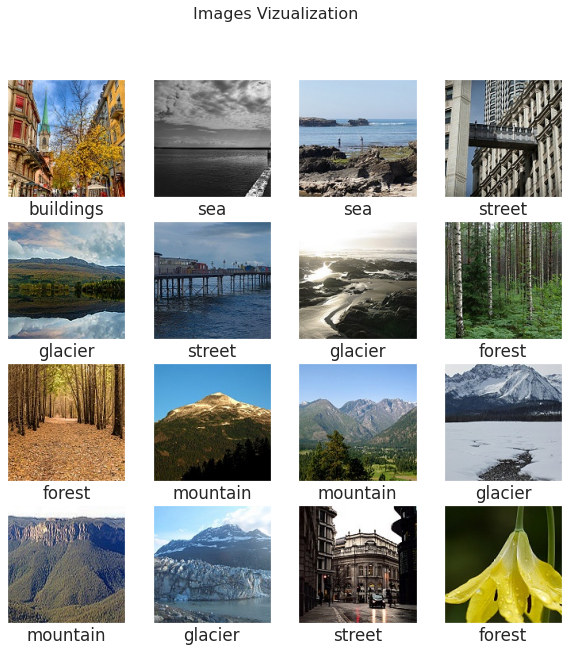

In [94]:
# Retutns 16 images from the prediction dataset
pred_imgs = get16PredicRandom()

# Returns the probability of beeing in each class for each image
predictions = model.predict(pred_imgs)
# Picking the highest probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

imgVisualization(pred_imgs, pred_labels)

### Confusion Matrix

<AxesSubplot:>

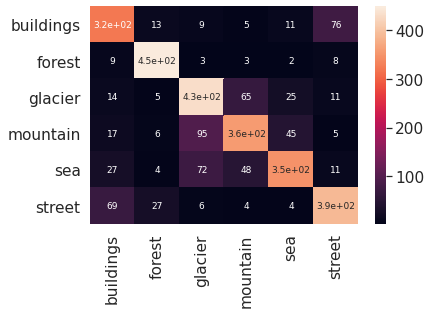

In [95]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_it, 3000 // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_it.classes, y_pred)
df_cm = pd.DataFrame(cm, label_enum, label_enum)
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9})

# CNN with Keras Tuner - Hyperparameters

Trying to find the best parameters for the network:
https://keras-team.github.io/keras-tuner/

### Defining Model Using HyperParameters

In [133]:
# Defining model function as in documentation
# We are using the same model as defined before in CNN
def build_model_cnn(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(hp.Choice('Conv_layer_1', [16, 32, 64]),
                                     (3, 3), activation = 'relu', 
                                     input_shape = (150, 150, 3)))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Conv2D(hp.Choice('Conv_layer_2', [16, 32, 64]),
                                     (3, 3),
                                     activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(hp.Choice('dense_layer1', values=[64, 128, 256, 512, 1024]), 
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(hp.Choice('dense_layer2', values=[64, 128, 256, 512, 1024]),
                                    activation='relu'))
    model.add(tf.keras.layers.Dense(hp.Choice('dense_layer3', values=[64, 128, 256, 512, 1024]),
                                    activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.5))
    model.add(tf.keras.layers.Dense(6,activation='softmax'))

    # Compile Model
    model.compile(optimizer = 'adam', 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics=['accuracy']
                 )
    
    return model

# Tunner instantiation
tuner = RandomSearch(
    build_model_cnn,
    objective='val_accuracy',
    max_trials=16,
    executions_per_trial=1,
    project_name='cnn_tunner',
    directory='./saved_tunner')

In [134]:
# Searching for the best model
tuner.search(train_it,
             steps_per_epoch=14034//BATCH_SIZE,
             validation_data=test_it,
             validation_steps=3000//BATCH_SIZE,
             epochs=10, 
             batch_size=BATCH_SIZE,
             verbose=2)

Epoch 1/10
438/438 - 14s - loss: 0.9345 - accuracy: 0.6386 - val_loss: 0.7958 - val_accuracy: 0.7008
Epoch 2/10
438/438 - 15s - loss: 0.5799 - accuracy: 0.7942 - val_loss: 0.6657 - val_accuracy: 0.7702
Epoch 3/10
438/438 - 14s - loss: 0.3546 - accuracy: 0.8811 - val_loss: 0.7807 - val_accuracy: 0.7695
Epoch 4/10
438/438 - 14s - loss: 0.1972 - accuracy: 0.9332 - val_loss: 1.0140 - val_accuracy: 0.7423
Epoch 5/10
438/438 - 15s - loss: 0.1145 - accuracy: 0.9631 - val_loss: 1.0381 - val_accuracy: 0.7709
Epoch 6/10
438/438 - 14s - loss: 0.0939 - accuracy: 0.9719 - val_loss: 1.1966 - val_accuracy: 0.7308
Epoch 7/10
438/438 - 14s - loss: 0.0688 - accuracy: 0.9794 - val_loss: 1.2472 - val_accuracy: 0.7581
Epoch 8/10
438/438 - 14s - loss: 0.0460 - accuracy: 0.9852 - val_loss: 1.1934 - val_accuracy: 0.7540
Epoch 9/10
438/438 - 14s - loss: 0.0514 - accuracy: 0.9843 - val_loss: 1.4136 - val_accuracy: 0.7392
Epoch 10/10
438/438 - 14s - loss: 0.0401 - accuracy: 0.9860 - val_loss: 1.6847 - val_accura

Epoch 1/10
438/438 - 28s - loss: 1.1651 - accuracy: 0.5354 - val_loss: 0.9383 - val_accuracy: 0.6196
Epoch 2/10
438/438 - 26s - loss: 0.8328 - accuracy: 0.6880 - val_loss: 0.9008 - val_accuracy: 0.6472
Epoch 3/10
438/438 - 26s - loss: 0.6124 - accuracy: 0.7862 - val_loss: 0.7379 - val_accuracy: 0.7530
Epoch 4/10
438/438 - 26s - loss: 0.4062 - accuracy: 0.8605 - val_loss: 0.9454 - val_accuracy: 0.7382
Epoch 5/10
438/438 - 26s - loss: 0.2352 - accuracy: 0.9237 - val_loss: 1.0239 - val_accuracy: 0.7544
Epoch 6/10
438/438 - 26s - loss: 0.1464 - accuracy: 0.9548 - val_loss: 1.2983 - val_accuracy: 0.7224
Epoch 7/10
438/438 - 26s - loss: 0.0882 - accuracy: 0.9744 - val_loss: 1.7116 - val_accuracy: 0.7311
Epoch 8/10
438/438 - 26s - loss: 0.0629 - accuracy: 0.9813 - val_loss: 1.6098 - val_accuracy: 0.7291
Epoch 9/10
438/438 - 26s - loss: 0.0680 - accuracy: 0.9819 - val_loss: 1.4992 - val_accuracy: 0.7301
Epoch 10/10
438/438 - 26s - loss: 0.0614 - accuracy: 0.9820 - val_loss: 1.7573 - val_accura

Epoch 1/10
438/438 - 26s - loss: 1.1370 - accuracy: 0.5486 - val_loss: 0.8892 - val_accuracy: 0.6546
Epoch 2/10
438/438 - 26s - loss: 0.7614 - accuracy: 0.7183 - val_loss: 0.7106 - val_accuracy: 0.7419
Epoch 3/10
438/438 - 26s - loss: 0.5720 - accuracy: 0.7976 - val_loss: 0.7690 - val_accuracy: 0.7446
Epoch 4/10
438/438 - 26s - loss: 0.3785 - accuracy: 0.8691 - val_loss: 0.8660 - val_accuracy: 0.7342
Epoch 5/10
438/438 - 27s - loss: 0.2213 - accuracy: 0.9292 - val_loss: 0.9831 - val_accuracy: 0.7423
Epoch 6/10
438/438 - 27s - loss: 0.1180 - accuracy: 0.9648 - val_loss: 1.3608 - val_accuracy: 0.7372
Epoch 7/10
438/438 - 26s - loss: 0.0961 - accuracy: 0.9707 - val_loss: 1.2767 - val_accuracy: 0.7389
Epoch 8/10
438/438 - 26s - loss: 0.0702 - accuracy: 0.9808 - val_loss: 1.4286 - val_accuracy: 0.7325
Epoch 9/10
438/438 - 26s - loss: 0.0562 - accuracy: 0.9831 - val_loss: 1.4055 - val_accuracy: 0.7419
Epoch 10/10
438/438 - 26s - loss: 0.0350 - accuracy: 0.9906 - val_loss: 1.5857 - val_accura

Epoch 1/10
438/438 - 38s - loss: 0.9952 - accuracy: 0.5991 - val_loss: 0.9428 - val_accuracy: 0.6496
Epoch 2/10
438/438 - 40s - loss: 0.6703 - accuracy: 0.7563 - val_loss: 0.7301 - val_accuracy: 0.7217
Epoch 3/10
438/438 - 40s - loss: 0.4328 - accuracy: 0.8502 - val_loss: 0.6823 - val_accuracy: 0.7810
Epoch 4/10
438/438 - 40s - loss: 0.2459 - accuracy: 0.9147 - val_loss: 0.9103 - val_accuracy: 0.7911
Epoch 5/10
438/438 - 37s - loss: 0.1276 - accuracy: 0.9608 - val_loss: 0.9754 - val_accuracy: 0.7759
Epoch 6/10
438/438 - 37s - loss: 0.1009 - accuracy: 0.9696 - val_loss: 1.0183 - val_accuracy: 0.7682
Epoch 7/10
438/438 - 37s - loss: 0.0683 - accuracy: 0.9799 - val_loss: 1.3124 - val_accuracy: 0.7631
Epoch 8/10
438/438 - 37s - loss: 0.0528 - accuracy: 0.9841 - val_loss: 1.3241 - val_accuracy: 0.7881
Epoch 9/10
438/438 - 37s - loss: 0.0527 - accuracy: 0.9834 - val_loss: 1.4733 - val_accuracy: 0.7406
Epoch 10/10
438/438 - 38s - loss: 0.0303 - accuracy: 0.9912 - val_loss: 1.3818 - val_accura

Epoch 1/10
438/438 - 16s - loss: 1.0122 - accuracy: 0.5988 - val_loss: 0.9280 - val_accuracy: 0.6452
Epoch 2/10
438/438 - 16s - loss: 0.6965 - accuracy: 0.7505 - val_loss: 0.7548 - val_accuracy: 0.7362
Epoch 3/10
438/438 - 16s - loss: 0.5175 - accuracy: 0.8160 - val_loss: 0.7321 - val_accuracy: 0.7534
Epoch 4/10
438/438 - 16s - loss: 0.3765 - accuracy: 0.8698 - val_loss: 0.7446 - val_accuracy: 0.7658
Epoch 5/10
438/438 - 16s - loss: 0.2507 - accuracy: 0.9172 - val_loss: 0.9370 - val_accuracy: 0.7561
Epoch 6/10
438/438 - 16s - loss: 0.1770 - accuracy: 0.9425 - val_loss: 1.0614 - val_accuracy: 0.7497
Epoch 7/10
438/438 - 16s - loss: 0.1248 - accuracy: 0.9582 - val_loss: 1.1666 - val_accuracy: 0.7271
Epoch 8/10
438/438 - 16s - loss: 0.0901 - accuracy: 0.9717 - val_loss: 1.5266 - val_accuracy: 0.7338
Epoch 9/10
438/438 - 16s - loss: 0.0908 - accuracy: 0.9716 - val_loss: 1.2204 - val_accuracy: 0.7348
Epoch 10/10
438/438 - 16s - loss: 0.0700 - accuracy: 0.9793 - val_loss: 1.4058 - val_accura

Epoch 1/10
438/438 - 17s - loss: 1.1484 - accuracy: 0.5466 - val_loss: 0.9140 - val_accuracy: 0.6412
Epoch 2/10
438/438 - 19s - loss: 0.7923 - accuracy: 0.7091 - val_loss: 0.8332 - val_accuracy: 0.7153
Epoch 3/10
438/438 - 20s - loss: 0.5749 - accuracy: 0.8031 - val_loss: 0.7548 - val_accuracy: 0.7460
Epoch 4/10
438/438 - 20s - loss: 0.3414 - accuracy: 0.8847 - val_loss: 0.8292 - val_accuracy: 0.7547
Epoch 5/10
438/438 - 17s - loss: 0.1854 - accuracy: 0.9405 - val_loss: 1.2136 - val_accuracy: 0.7449
Epoch 6/10
438/438 - 17s - loss: 0.1088 - accuracy: 0.9678 - val_loss: 1.2519 - val_accuracy: 0.7453
Epoch 7/10
438/438 - 17s - loss: 0.0799 - accuracy: 0.9765 - val_loss: 1.2657 - val_accuracy: 0.7190
Epoch 8/10
438/438 - 16s - loss: 0.0697 - accuracy: 0.9804 - val_loss: 1.3187 - val_accuracy: 0.7463
Epoch 9/10
438/438 - 17s - loss: 0.0453 - accuracy: 0.9856 - val_loss: 1.5721 - val_accuracy: 0.7321
Epoch 10/10
438/438 - 17s - loss: 0.0418 - accuracy: 0.9871 - val_loss: 1.5878 - val_accura

Epoch 1/10
438/438 - 16s - loss: 1.0434 - accuracy: 0.5936 - val_loss: 0.8108 - val_accuracy: 0.7015
Epoch 2/10
438/438 - 16s - loss: 0.6867 - accuracy: 0.7565 - val_loss: 0.6898 - val_accuracy: 0.7544
Epoch 3/10
438/438 - 16s - loss: 0.4811 - accuracy: 0.8342 - val_loss: 0.7165 - val_accuracy: 0.7618
Epoch 4/10
438/438 - 16s - loss: 0.3417 - accuracy: 0.8822 - val_loss: 0.7461 - val_accuracy: 0.7635
Epoch 5/10
438/438 - 16s - loss: 0.2334 - accuracy: 0.9219 - val_loss: 0.9469 - val_accuracy: 0.7439
Epoch 6/10
438/438 - 16s - loss: 0.1726 - accuracy: 0.9447 - val_loss: 1.1061 - val_accuracy: 0.7460
Epoch 7/10
438/438 - 16s - loss: 0.1263 - accuracy: 0.9603 - val_loss: 1.1898 - val_accuracy: 0.7018
Epoch 8/10
438/438 - 16s - loss: 0.1148 - accuracy: 0.9633 - val_loss: 1.2082 - val_accuracy: 0.7352
Epoch 9/10
438/438 - 16s - loss: 0.0835 - accuracy: 0.9747 - val_loss: 1.4594 - val_accuracy: 0.7200
Epoch 10/10
438/438 - 16s - loss: 0.0813 - accuracy: 0.9759 - val_loss: 1.5291 - val_accura

Epoch 1/10
438/438 - 18s - loss: 1.4806 - accuracy: 0.3593 - val_loss: 1.0316 - val_accuracy: 0.5795
Epoch 2/10
438/438 - 19s - loss: 1.0283 - accuracy: 0.5911 - val_loss: 0.8883 - val_accuracy: 0.6533
Epoch 3/10
438/438 - 19s - loss: 0.8206 - accuracy: 0.6871 - val_loss: 0.8828 - val_accuracy: 0.6786
Epoch 4/10
438/438 - 19s - loss: 0.5768 - accuracy: 0.7948 - val_loss: 0.8527 - val_accuracy: 0.7123
Epoch 5/10
438/438 - 19s - loss: 0.3704 - accuracy: 0.8812 - val_loss: 0.9179 - val_accuracy: 0.7284
Epoch 6/10
438/438 - 18s - loss: 0.2272 - accuracy: 0.9309 - val_loss: 1.1650 - val_accuracy: 0.7062
Epoch 7/10
438/438 - 18s - loss: 0.1337 - accuracy: 0.9661 - val_loss: 1.5493 - val_accuracy: 0.6971
Epoch 8/10
438/438 - 18s - loss: 0.1139 - accuracy: 0.9699 - val_loss: 1.8213 - val_accuracy: 0.6991
Epoch 9/10
438/438 - 18s - loss: 0.0702 - accuracy: 0.9818 - val_loss: 1.6716 - val_accuracy: 0.6944
Epoch 10/10
438/438 - 18s - loss: 0.0631 - accuracy: 0.9851 - val_loss: 1.8504 - val_accura

Epoch 1/10
438/438 - 22s - loss: 1.3418 - accuracy: 0.4665 - val_loss: 0.8982 - val_accuracy: 0.6449
Epoch 2/10
438/438 - 25s - loss: 0.9067 - accuracy: 0.6674 - val_loss: 0.7706 - val_accuracy: 0.7086
Epoch 3/10
438/438 - 25s - loss: 0.6648 - accuracy: 0.7734 - val_loss: 0.7831 - val_accuracy: 0.7406
Epoch 4/10
438/438 - 25s - loss: 0.4394 - accuracy: 0.8607 - val_loss: 0.7299 - val_accuracy: 0.7706
Epoch 5/10
438/438 - 22s - loss: 0.2610 - accuracy: 0.9174 - val_loss: 0.9170 - val_accuracy: 0.7689
Epoch 6/10
438/438 - 24s - loss: 0.1599 - accuracy: 0.9530 - val_loss: 1.0761 - val_accuracy: 0.7766
Epoch 7/10
438/438 - 22s - loss: 0.1200 - accuracy: 0.9665 - val_loss: 1.1824 - val_accuracy: 0.7756
Epoch 8/10
438/438 - 22s - loss: 0.0957 - accuracy: 0.9771 - val_loss: 1.4070 - val_accuracy: 0.7564
Epoch 9/10
438/438 - 22s - loss: 0.0656 - accuracy: 0.9835 - val_loss: 1.4655 - val_accuracy: 0.7628
Epoch 10/10
438/438 - 22s - loss: 0.0484 - accuracy: 0.9883 - val_loss: 1.7033 - val_accura

Epoch 1/10
438/438 - 16s - loss: 1.1162 - accuracy: 0.5662 - val_loss: 0.8424 - val_accuracy: 0.6880
Epoch 2/10
438/438 - 16s - loss: 0.7649 - accuracy: 0.7259 - val_loss: 0.7284 - val_accuracy: 0.7412
Epoch 3/10
438/438 - 16s - loss: 0.5542 - accuracy: 0.8110 - val_loss: 0.7377 - val_accuracy: 0.7540
Epoch 4/10
438/438 - 16s - loss: 0.3969 - accuracy: 0.8701 - val_loss: 0.7092 - val_accuracy: 0.7729
Epoch 5/10
438/438 - 16s - loss: 0.2719 - accuracy: 0.9119 - val_loss: 0.8604 - val_accuracy: 0.7449
Epoch 6/10
438/438 - 16s - loss: 0.1824 - accuracy: 0.9425 - val_loss: 0.9969 - val_accuracy: 0.7530
Epoch 7/10
438/438 - 16s - loss: 0.1148 - accuracy: 0.9641 - val_loss: 1.2755 - val_accuracy: 0.7315
Epoch 8/10
438/438 - 16s - loss: 0.0854 - accuracy: 0.9744 - val_loss: 1.2384 - val_accuracy: 0.7604
Epoch 9/10
438/438 - 16s - loss: 0.0765 - accuracy: 0.9779 - val_loss: 1.3399 - val_accuracy: 0.7520
Epoch 10/10
438/438 - 16s - loss: 0.0780 - accuracy: 0.9780 - val_loss: 1.5626 - val_accura

Epoch 1/10
438/438 - 23s - loss: 1.1486 - accuracy: 0.5444 - val_loss: 0.8055 - val_accuracy: 0.6995
Epoch 2/10
438/438 - 22s - loss: 0.7275 - accuracy: 0.7408 - val_loss: 0.6662 - val_accuracy: 0.7621
Epoch 3/10
438/438 - 22s - loss: 0.4989 - accuracy: 0.8285 - val_loss: 0.6492 - val_accuracy: 0.7679
Epoch 4/10
438/438 - 22s - loss: 0.3401 - accuracy: 0.8862 - val_loss: 0.7382 - val_accuracy: 0.7786
Epoch 5/10
438/438 - 22s - loss: 0.2026 - accuracy: 0.9360 - val_loss: 0.8484 - val_accuracy: 0.7685
Epoch 6/10
438/438 - 21s - loss: 0.1263 - accuracy: 0.9616 - val_loss: 0.9839 - val_accuracy: 0.7608
Epoch 7/10
438/438 - 21s - loss: 0.0760 - accuracy: 0.9789 - val_loss: 1.1890 - val_accuracy: 0.7537
Epoch 8/10
438/438 - 21s - loss: 0.0748 - accuracy: 0.9781 - val_loss: 1.4457 - val_accuracy: 0.7358
Epoch 9/10
438/438 - 21s - loss: 0.0665 - accuracy: 0.9792 - val_loss: 1.6197 - val_accuracy: 0.7325
Epoch 10/10
438/438 - 21s - loss: 0.0600 - accuracy: 0.9831 - val_loss: 1.5604 - val_accura

Epoch 1/10
438/438 - 32s - loss: 1.1931 - accuracy: 0.5261 - val_loss: 0.8916 - val_accuracy: 0.6422
Epoch 2/10
438/438 - 35s - loss: 0.9194 - accuracy: 0.6585 - val_loss: 0.8512 - val_accuracy: 0.6819
Epoch 3/10
438/438 - 35s - loss: 0.7743 - accuracy: 0.7217 - val_loss: 0.7307 - val_accuracy: 0.7392
Epoch 4/10
438/438 - 32s - loss: 0.5934 - accuracy: 0.7949 - val_loss: 0.8167 - val_accuracy: 0.7113
Epoch 5/10
438/438 - 32s - loss: 0.3909 - accuracy: 0.8731 - val_loss: 0.9554 - val_accuracy: 0.7372
Epoch 6/10
438/438 - 35s - loss: 0.2854 - accuracy: 0.9157 - val_loss: 1.0037 - val_accuracy: 0.7439
Epoch 7/10
438/438 - 32s - loss: 0.1613 - accuracy: 0.9557 - val_loss: 1.1671 - val_accuracy: 0.7173
Epoch 8/10
438/438 - 32s - loss: 0.1090 - accuracy: 0.9690 - val_loss: 1.6853 - val_accuracy: 0.7197
Epoch 9/10
438/438 - 32s - loss: 0.0810 - accuracy: 0.9778 - val_loss: 2.0044 - val_accuracy: 0.7423
Epoch 10/10
438/438 - 35s - loss: 0.0551 - accuracy: 0.9849 - val_loss: 2.0726 - val_accura

Epoch 1/10
438/438 - 55s - loss: 1.3333 - accuracy: 0.4626 - val_loss: 1.0232 - val_accuracy: 0.5745
Epoch 2/10
438/438 - 64s - loss: 0.9598 - accuracy: 0.6195 - val_loss: 0.9992 - val_accuracy: 0.5974
Epoch 3/10
438/438 - 64s - loss: 0.7497 - accuracy: 0.7223 - val_loss: 0.7974 - val_accuracy: 0.7096
Epoch 4/10
438/438 - 64s - loss: 0.4553 - accuracy: 0.8472 - val_loss: 0.8661 - val_accuracy: 0.7372
Epoch 5/10
438/438 - 54s - loss: 0.2109 - accuracy: 0.9335 - val_loss: 1.1616 - val_accuracy: 0.7321
Epoch 6/10
438/438 - 54s - loss: 0.1126 - accuracy: 0.9691 - val_loss: 1.4739 - val_accuracy: 0.7045
Epoch 7/10
438/438 - 54s - loss: 0.0854 - accuracy: 0.9774 - val_loss: 1.7801 - val_accuracy: 0.6742
Epoch 8/10
438/438 - 54s - loss: 0.0677 - accuracy: 0.9815 - val_loss: 1.9263 - val_accuracy: 0.7294
Epoch 9/10
438/438 - 54s - loss: 0.0422 - accuracy: 0.9874 - val_loss: 2.1416 - val_accuracy: 0.6931
Epoch 10/10
438/438 - 54s - loss: 0.0541 - accuracy: 0.9864 - val_loss: 2.0164 - val_accura

Epoch 1/10
438/438 - 12s - loss: 1.1567 - accuracy: 0.5507 - val_loss: 0.8806 - val_accuracy: 0.6631
Epoch 2/10
438/438 - 12s - loss: 0.8091 - accuracy: 0.7115 - val_loss: 0.7272 - val_accuracy: 0.7301
Epoch 3/10
438/438 - 12s - loss: 0.6085 - accuracy: 0.7895 - val_loss: 0.7748 - val_accuracy: 0.7237
Epoch 4/10
438/438 - 12s - loss: 0.4622 - accuracy: 0.8473 - val_loss: 0.6785 - val_accuracy: 0.7652
Epoch 5/10
438/438 - 12s - loss: 0.3354 - accuracy: 0.8922 - val_loss: 0.7464 - val_accuracy: 0.7530
Epoch 6/10
438/438 - 12s - loss: 0.2600 - accuracy: 0.9190 - val_loss: 0.8204 - val_accuracy: 0.7695
Epoch 7/10
438/438 - 12s - loss: 0.1668 - accuracy: 0.9506 - val_loss: 1.3977 - val_accuracy: 0.6712
Epoch 8/10
438/438 - 12s - loss: 0.1435 - accuracy: 0.9570 - val_loss: 1.0962 - val_accuracy: 0.7345
Epoch 9/10
438/438 - 12s - loss: 0.0932 - accuracy: 0.9721 - val_loss: 1.2842 - val_accuracy: 0.7305
Epoch 10/10
438/438 - 12s - loss: 0.0986 - accuracy: 0.9726 - val_loss: 1.4404 - val_accura

Epoch 1/10
438/438 - 31s - loss: 1.2568 - accuracy: 0.5177 - val_loss: 0.9391 - val_accuracy: 0.6354
Epoch 2/10
438/438 - 36s - loss: 0.8205 - accuracy: 0.7039 - val_loss: 0.8607 - val_accuracy: 0.6803
Epoch 3/10
438/438 - 36s - loss: 0.5465 - accuracy: 0.8140 - val_loss: 0.6844 - val_accuracy: 0.7709
Epoch 4/10
438/438 - 31s - loss: 0.3150 - accuracy: 0.8965 - val_loss: 0.9037 - val_accuracy: 0.7608
Epoch 5/10
438/438 - 31s - loss: 0.1667 - accuracy: 0.9515 - val_loss: 1.1161 - val_accuracy: 0.7433
Epoch 6/10
438/438 - 31s - loss: 0.1104 - accuracy: 0.9703 - val_loss: 1.3095 - val_accuracy: 0.7537
Epoch 7/10
438/438 - 31s - loss: 0.0502 - accuracy: 0.9866 - val_loss: 1.4924 - val_accuracy: 0.7554
Epoch 8/10
438/438 - 31s - loss: 0.0610 - accuracy: 0.9826 - val_loss: 1.3569 - val_accuracy: 0.7463
Epoch 9/10
438/438 - 31s - loss: 0.0630 - accuracy: 0.9831 - val_loss: 1.8864 - val_accuracy: 0.7241
Epoch 10/10
438/438 - 31s - loss: 0.0392 - accuracy: 0.9892 - val_loss: 1.7932 - val_accura

Epoch 1/10
438/438 - 16s - loss: 1.1418 - accuracy: 0.5441 - val_loss: 0.8610 - val_accuracy: 0.6728
Epoch 2/10
438/438 - 17s - loss: 0.7564 - accuracy: 0.7112 - val_loss: 0.7026 - val_accuracy: 0.7294
Epoch 3/10
438/438 - 17s - loss: 0.5251 - accuracy: 0.8124 - val_loss: 0.6888 - val_accuracy: 0.7567
Epoch 4/10
438/438 - 16s - loss: 0.3119 - accuracy: 0.8933 - val_loss: 0.7561 - val_accuracy: 0.7598
Epoch 5/10
438/438 - 16s - loss: 0.1476 - accuracy: 0.9519 - val_loss: 0.9443 - val_accuracy: 0.7473
Epoch 6/10
438/438 - 16s - loss: 0.0836 - accuracy: 0.9740 - val_loss: 1.2525 - val_accuracy: 0.7352
Epoch 7/10
438/438 - 16s - loss: 0.0793 - accuracy: 0.9772 - val_loss: 1.2893 - val_accuracy: 0.7268
Epoch 8/10
438/438 - 16s - loss: 0.0604 - accuracy: 0.9825 - val_loss: 1.2769 - val_accuracy: 0.7601
Epoch 9/10
438/438 - 16s - loss: 0.0395 - accuracy: 0.9895 - val_loss: 1.3327 - val_accuracy: 0.7490
Epoch 10/10
438/438 - 16s - loss: 0.0357 - accuracy: 0.9895 - val_loss: 1.4769 - val_accura

INFO:tensorflow:Oracle triggered exit


In [135]:
# Get the best model found with the best parameters
cnn_tunned_model = tuner.get_best_models()[0]

### Saving Model Information

In [136]:
# Save Model for future use
!mkdir -p saved_model
cnn_tunned_model.save('saved_model/cnn_tunned_model')

# Shows model specifications
cnn_tunned_model.summary()

INFO:tensorflow:Assets written to: saved_model/cnn_tunned_model/assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               21233920  
___________________________________________________

### Load Trained Model

In [137]:
# If it has already beeeing trainned
cnn_tunned_model = tf.keras.models.load_model('saved_model/cnn_tunned_model')

### Model Evaluation

In [138]:
# evaluate model
cnn_tunned_model.evaluate(test_it, steps=3000//BATCH_SIZE, verbose=2)

93/93 - 3s - loss: 0.9103 - accuracy: 0.7911


[0.9102773070335388, 0.7911050915718079]

### Predicting Some Random Images with CNN Tunned Model

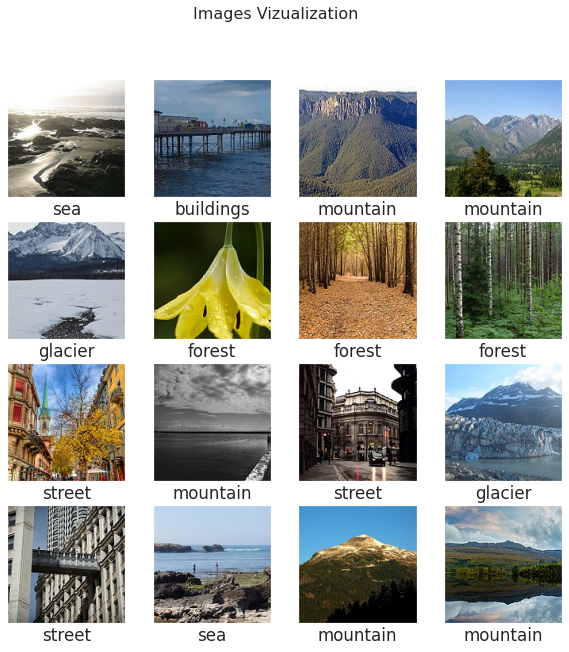

In [139]:
# Retutns 16 images from the prediction dataset
pred_imgs = get16PredicRandom()

# Returns the probability of beeing in each class for each image
predictions = cnn_tunned_model.predict(pred_imgs)
# Picking the highest probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

imgVisualization(pred_imgs, pred_labels)

### Confusion Matrix

<AxesSubplot:>

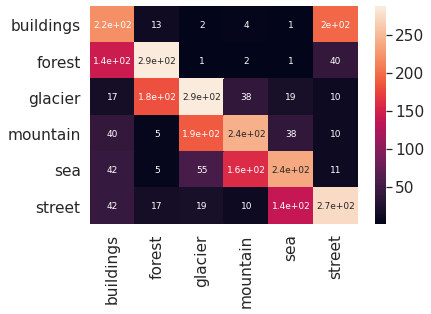

In [140]:
#Confution Matrix and Classification Report
Y_pred = cnn_tunned_model.predict_generator(test_it, 3000 // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_it.classes, y_pred)
df_cm = pd.DataFrame(cm, label_enum, label_enum)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

# Multilayer Perceptron

### Model Specification and Training

In [107]:
model2 = tf.keras.Sequential()

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(512, activation='relu'))
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dense(6, activation='softmax'))

# Compile Model
model2.compile(optimizer = 'adam', 
          loss = 'sparse_categorical_crossentropy', 
          metrics=['accuracy']
         )

In [108]:
# Fitting model
history = model2.fit_generator(train_it, 
                    steps_per_epoch=14034//BATCH_SIZE,
                    validation_data=test_it, 
                    validation_steps=3000//BATCH_SIZE,
                    epochs=10,
                    verbose=2)

Epoch 1/10
438/438 - 12s - loss: 3.0048 - accuracy: 0.4042 - val_loss: 1.4678 - val_accuracy: 0.4441
Epoch 2/10
438/438 - 12s - loss: 1.3305 - accuracy: 0.4993 - val_loss: 1.2775 - val_accuracy: 0.4960
Epoch 3/10
438/438 - 12s - loss: 1.2307 - accuracy: 0.5329 - val_loss: 1.3068 - val_accuracy: 0.4825
Epoch 4/10
438/438 - 12s - loss: 1.1961 - accuracy: 0.5431 - val_loss: 1.2206 - val_accuracy: 0.5401
Epoch 5/10
438/438 - 12s - loss: 1.1340 - accuracy: 0.5619 - val_loss: 1.1460 - val_accuracy: 0.5745
Epoch 6/10
438/438 - 12s - loss: 1.1014 - accuracy: 0.5834 - val_loss: 1.2716 - val_accuracy: 0.5128
Epoch 7/10
438/438 - 12s - loss: 1.0849 - accuracy: 0.5907 - val_loss: 1.1537 - val_accuracy: 0.5603
Epoch 8/10
438/438 - 12s - loss: 1.0370 - accuracy: 0.6064 - val_loss: 1.1597 - val_accuracy: 0.5745
Epoch 9/10
438/438 - 12s - loss: 1.0381 - accuracy: 0.6018 - val_loss: 1.1298 - val_accuracy: 0.5728
Epoch 10/10
438/438 - 12s - loss: 0.9998 - accuracy: 0.6253 - val_loss: 1.2642 - val_accura

### Model History Evaluation

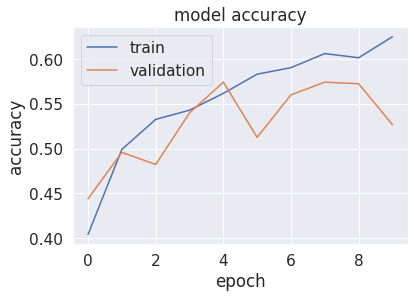

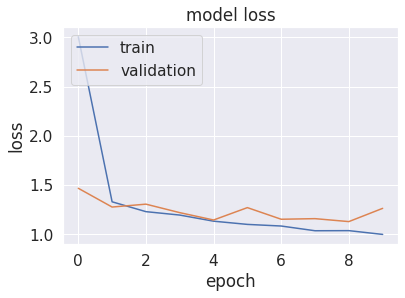

In [109]:
plot_hist(history)

### Saving Model Information

In [110]:
# Save history
!mkdir -p train_history
with open('./train_history/mlp.pickle','wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [111]:
# Save Model for future use
!mkdir -p saved_model
model2.save('saved_model/mlp_model')

# Shows model specifications
model2.summary()

INFO:tensorflow:Assets written to: saved_model/mlp_model/assets
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  34560512  
_________________________________________________________________
dense_5 (Dense)              multiple                  131328    
_________________________________________________________________
dense_6 (Dense)              multiple                  32896     
_________________________________________________________________
dense_7 (Dense)              multiple                  774       
Total params: 34,725,510
Trainable params: 34,725,510
Non-trainable params: 0
_________________________________________________________________


### Load Saved Model 

In [112]:
# If it has already beeeing trainned
model2 = tf.keras.models.load_model('saved_model/mlp_model')

### Model Evaluation

In [113]:
# evaluate model
loss = model2.evaluate(train_it, steps=3000//BATCH_SIZE, verbose=2)

93/93 - 2s - loss: 1.0585 - accuracy: 0.5958


### Predicting Some Random Images with Multilayer Perceptron

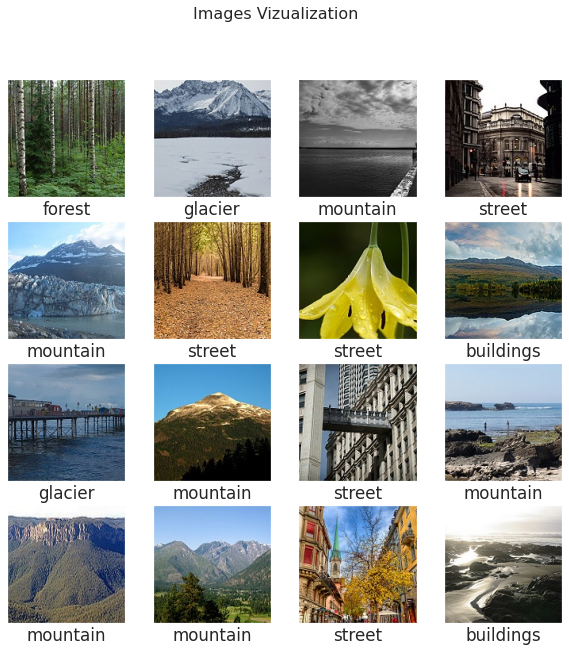

In [114]:
# Retutns 16 images from the prediction dataset
pred_imgs = get16PredicRandom()

# Returns the probability of beeing in each class for each image
predictions = model2.predict(pred_imgs)
# Picking the highest probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

imgVisualization(pred_imgs, pred_labels)

### Confusion Matrix

<AxesSubplot:>

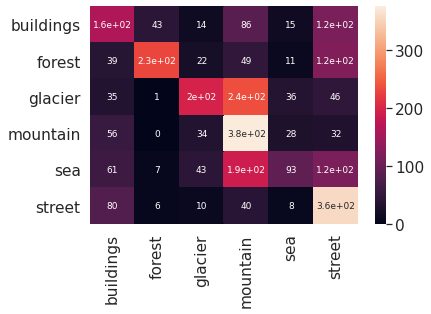

In [115]:
#Confution Matrix and Classification Report
Y_pred = model2.predict_generator(test_it, 3000 // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_it.classes, y_pred)
df_cm = pd.DataFrame(cm, label_enum, label_enum)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

# Multilayer Perceptron with Keras Tuner - Hyperparameters

Trying to find the best parameters for the network:
https://keras-team.github.io/keras-tuner/

### Defining Model Using Hyperparameters

In [116]:
# Defining model function as in documentation
# We are using the same model as defined before in CNN
def build_model_mlp(hp):
    # Model Creation
    model2 = tf.keras.Sequential()

    model2.add(tf.keras.layers.Flatten())
    model2.add(tf.keras.layers.Dense(hp.Choice('dense_layer1', values=[64, 128, 256, 512, 1024]),
                                     activation='relu'))
    model2.add(tf.keras.layers.Dense(hp.Choice('dense_layer2', values=[64, 128, 256, 512, 1024]),
                                     activation='relu'))
    model2.add(tf.keras.layers.Dense(hp.Choice('dense_layer3', values=[64, 128, 256, 512, 1024]),
                                     activation='relu'))
    model2.add(tf.keras.layers.Dense(6, activation='softmax'))

    # Compile Model
    model2.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy']
             )
    
    return model

# Tunner instantiation
tuner2 = RandomSearch(
    build_model_mlp,
    objective='val_accuracy',
    max_trials=16,
    executions_per_trial=2,
    project_name='mlp_tunner',
    directory='./saved_tunner')

In [117]:
# Searching
tuner2.search(train_it,
             steps_per_epoch=14034//BATCH_SIZE,
             validation_data=test_it,
             validation_steps=3000//BATCH_SIZE,
             epochs=10, 
             batch_size=BATCH_SIZE,
             verbose=2)

Epoch 1/10
438/438 - 19s - loss: 0.0784 - accuracy: 0.9810 - val_loss: 1.6905 - val_accuracy: 0.7685
Epoch 2/10
438/438 - 20s - loss: 0.0376 - accuracy: 0.9913 - val_loss: 2.1188 - val_accuracy: 0.7739
Epoch 3/10
438/438 - 20s - loss: 0.0404 - accuracy: 0.9896 - val_loss: 1.9512 - val_accuracy: 0.7770
Epoch 4/10
438/438 - 19s - loss: 0.0501 - accuracy: 0.9874 - val_loss: 3.2285 - val_accuracy: 0.7251
Epoch 5/10
438/438 - 19s - loss: 0.0576 - accuracy: 0.9851 - val_loss: 1.7408 - val_accuracy: 0.7591
Epoch 6/10
438/438 - 19s - loss: 0.0416 - accuracy: 0.9909 - val_loss: 1.9913 - val_accuracy: 0.7591
Epoch 7/10
438/438 - 19s - loss: 0.0253 - accuracy: 0.9934 - val_loss: 2.4492 - val_accuracy: 0.7655
Epoch 8/10
438/438 - 19s - loss: 0.0319 - accuracy: 0.9915 - val_loss: 1.9160 - val_accuracy: 0.7668
Epoch 9/10
438/438 - 19s - loss: 0.0215 - accuracy: 0.9946 - val_loss: 1.8763 - val_accuracy: 0.7439
Epoch 10/10
438/438 - 19s - loss: 0.0245 - accuracy: 0.9935 - val_loss: 2.5186 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0263 - accuracy: 0.9931 - val_loss: 2.7207 - val_accuracy: 0.7483
Epoch 2/10
438/438 - 20s - loss: 0.0280 - accuracy: 0.9937 - val_loss: 2.3846 - val_accuracy: 0.7557
Epoch 3/10
438/438 - 19s - loss: 0.0075 - accuracy: 0.9976 - val_loss: 3.3131 - val_accuracy: 0.7463
Epoch 4/10
438/438 - 19s - loss: 0.0246 - accuracy: 0.9941 - val_loss: 2.1257 - val_accuracy: 0.7537
Epoch 5/10
438/438 - 20s - loss: 0.0175 - accuracy: 0.9957 - val_loss: 2.5157 - val_accuracy: 0.7581
Epoch 6/10
438/438 - 21s - loss: 0.0036 - accuracy: 0.9984 - val_loss: 2.9949 - val_accuracy: 0.7594
Epoch 7/10
438/438 - 19s - loss: 0.0298 - accuracy: 0.9931 - val_loss: 2.8492 - val_accuracy: 0.7355
Epoch 8/10
438/438 - 19s - loss: 0.0141 - accuracy: 0.9965 - val_loss: 3.0764 - val_accuracy: 0.7318
Epoch 9/10
438/438 - 21s - loss: 0.0102 - accuracy: 0.9971 - val_loss: 2.8460 - val_accuracy: 0.7655
Epoch 10/10
438/438 - 20s - loss: 0.0126 - accuracy: 0.9958 - val_loss: 3.2348 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0026 - accuracy: 0.9991 - val_loss: 4.6093 - val_accuracy: 0.7453
Epoch 2/10
438/438 - 19s - loss: 0.0185 - accuracy: 0.9964 - val_loss: 2.3898 - val_accuracy: 0.7136
Epoch 3/10
438/438 - 19s - loss: 0.0317 - accuracy: 0.9919 - val_loss: 3.2812 - val_accuracy: 0.7449
Epoch 4/10
438/438 - 19s - loss: 0.0354 - accuracy: 0.9929 - val_loss: 3.3042 - val_accuracy: 0.7237
Epoch 5/10
438/438 - 20s - loss: 0.0179 - accuracy: 0.9961 - val_loss: 3.0602 - val_accuracy: 0.7554
Epoch 6/10
438/438 - 20s - loss: 0.0031 - accuracy: 0.9986 - val_loss: 3.7845 - val_accuracy: 0.7601
Epoch 7/10
438/438 - 19s - loss: 0.0173 - accuracy: 0.9964 - val_loss: 3.7806 - val_accuracy: 0.7460
Epoch 8/10
438/438 - 19s - loss: 0.0062 - accuracy: 0.9979 - val_loss: 4.4528 - val_accuracy: 0.7187
Epoch 9/10
438/438 - 19s - loss: 0.0157 - accuracy: 0.9964 - val_loss: 4.6317 - val_accuracy: 0.6890
Epoch 10/10
438/438 - 19s - loss: 0.0167 - accuracy: 0.9954 - val_loss: 3.8465 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0221 - accuracy: 0.9959 - val_loss: 3.0724 - val_accuracy: 0.7251
Epoch 2/10
438/438 - 20s - loss: 0.0338 - accuracy: 0.9940 - val_loss: 3.7334 - val_accuracy: 0.7433
Epoch 3/10
438/438 - 19s - loss: 0.0087 - accuracy: 0.9976 - val_loss: 4.0779 - val_accuracy: 0.7335
Epoch 4/10
438/438 - 20s - loss: 0.0086 - accuracy: 0.9972 - val_loss: 4.2583 - val_accuracy: 0.7473
Epoch 5/10
438/438 - 19s - loss: 0.0024 - accuracy: 0.9985 - val_loss: 6.4286 - val_accuracy: 0.7453
Epoch 6/10
438/438 - 19s - loss: 0.0459 - accuracy: 0.9916 - val_loss: 3.9302 - val_accuracy: 0.7396
Epoch 7/10
438/438 - 20s - loss: 0.0061 - accuracy: 0.9977 - val_loss: 3.5728 - val_accuracy: 0.7476
Epoch 8/10
438/438 - 19s - loss: 0.0074 - accuracy: 0.9980 - val_loss: 4.7364 - val_accuracy: 0.7375
Epoch 9/10
438/438 - 20s - loss: 0.0065 - accuracy: 0.9988 - val_loss: 4.4866 - val_accuracy: 0.7510
Epoch 10/10
438/438 - 19s - loss: 0.0407 - accuracy: 0.9921 - val_loss: 3.4267 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0253 - accuracy: 0.9967 - val_loss: 5.4654 - val_accuracy: 0.6651
Epoch 2/10
438/438 - 20s - loss: 0.0269 - accuracy: 0.9946 - val_loss: 4.5326 - val_accuracy: 0.7342
Epoch 3/10
438/438 - 19s - loss: 0.0182 - accuracy: 0.9964 - val_loss: 4.1934 - val_accuracy: 0.6988
Epoch 4/10
438/438 - 20s - loss: 0.0084 - accuracy: 0.9979 - val_loss: 5.5112 - val_accuracy: 0.7402
Epoch 5/10
438/438 - 20s - loss: 0.0135 - accuracy: 0.9966 - val_loss: 4.2220 - val_accuracy: 0.7429
Epoch 6/10
438/438 - 19s - loss: 0.0101 - accuracy: 0.9981 - val_loss: 4.6798 - val_accuracy: 0.7358
Epoch 7/10
438/438 - 19s - loss: 0.0027 - accuracy: 0.9988 - val_loss: 5.6922 - val_accuracy: 0.7416
Epoch 8/10
438/438 - 19s - loss: 0.0030 - accuracy: 0.9991 - val_loss: 4.9287 - val_accuracy: 0.7375
Epoch 9/10
438/438 - 19s - loss: 0.0020 - accuracy: 0.9989 - val_loss: 5.8708 - val_accuracy: 0.7426
Epoch 10/10
438/438 - 20s - loss: 0.0012 - accuracy: 0.9991 - val_loss: 6.3569 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0068 - accuracy: 0.9976 - val_loss: 5.9343 - val_accuracy: 0.7369
Epoch 2/10
438/438 - 19s - loss: 0.0038 - accuracy: 0.9989 - val_loss: 7.6353 - val_accuracy: 0.7281
Epoch 3/10
438/438 - 19s - loss: 0.0103 - accuracy: 0.9974 - val_loss: 4.6488 - val_accuracy: 0.7369
Epoch 4/10
438/438 - 19s - loss: 0.0265 - accuracy: 0.9958 - val_loss: 7.1438 - val_accuracy: 0.7190
Epoch 5/10
438/438 - 20s - loss: 0.0350 - accuracy: 0.9957 - val_loss: 5.0333 - val_accuracy: 0.7419
Epoch 6/10
438/438 - 19s - loss: 0.0305 - accuracy: 0.9962 - val_loss: 4.8548 - val_accuracy: 0.7129
Epoch 7/10
438/438 - 20s - loss: 0.0132 - accuracy: 0.9964 - val_loss: 4.3426 - val_accuracy: 0.7483
Epoch 8/10
438/438 - 19s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 5.0266 - val_accuracy: 0.7399
Epoch 9/10
438/438 - 20s - loss: 0.0128 - accuracy: 0.9981 - val_loss: 4.4805 - val_accuracy: 0.7487
Epoch 10/10
438/438 - 20s - loss: 0.0035 - accuracy: 0.9988 - val_loss: 5.3113 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0052 - accuracy: 0.9986 - val_loss: 4.1122 - val_accuracy: 0.7483
Epoch 2/10
438/438 - 20s - loss: 0.0042 - accuracy: 0.9985 - val_loss: 4.7291 - val_accuracy: 0.7527
Epoch 3/10
438/438 - 19s - loss: 0.0020 - accuracy: 0.9992 - val_loss: 5.5493 - val_accuracy: 0.7500
Epoch 4/10
438/438 - 19s - loss: 0.0022 - accuracy: 0.9988 - val_loss: 5.5163 - val_accuracy: 0.7490
Epoch 5/10
438/438 - 19s - loss: 0.0018 - accuracy: 0.9991 - val_loss: 5.1940 - val_accuracy: 0.7476
Epoch 6/10
438/438 - 19s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 5.4931 - val_accuracy: 0.7513
Epoch 7/10
438/438 - 19s - loss: 0.0890 - accuracy: 0.9883 - val_loss: 6.1850 - val_accuracy: 0.7028
Epoch 8/10
438/438 - 19s - loss: 0.0401 - accuracy: 0.9951 - val_loss: 4.2146 - val_accuracy: 0.7129
Epoch 9/10
438/438 - 19s - loss: 0.0249 - accuracy: 0.9968 - val_loss: 5.5290 - val_accuracy: 0.7500
Epoch 10/10
438/438 - 19s - loss: 0.0113 - accuracy: 0.9971 - val_loss: 4.8851 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0101 - accuracy: 0.9977 - val_loss: 5.6973 - val_accuracy: 0.7456
Epoch 2/10
438/438 - 19s - loss: 0.0151 - accuracy: 0.9973 - val_loss: 6.1388 - val_accuracy: 0.7402
Epoch 3/10
438/438 - 19s - loss: 0.0030 - accuracy: 0.9986 - val_loss: 5.5026 - val_accuracy: 0.7426
Epoch 4/10
438/438 - 19s - loss: 0.0132 - accuracy: 0.9969 - val_loss: 6.2538 - val_accuracy: 0.7321
Epoch 5/10
438/438 - 19s - loss: 0.0236 - accuracy: 0.9969 - val_loss: 7.3634 - val_accuracy: 0.7423
Epoch 6/10
438/438 - 19s - loss: 0.0103 - accuracy: 0.9977 - val_loss: 4.6123 - val_accuracy: 0.7402
Epoch 7/10
438/438 - 19s - loss: 0.0110 - accuracy: 0.9974 - val_loss: 5.9779 - val_accuracy: 0.7355
Epoch 8/10
438/438 - 19s - loss: 0.0231 - accuracy: 0.9960 - val_loss: 5.6241 - val_accuracy: 0.7298
Epoch 9/10
438/438 - 19s - loss: 0.0036 - accuracy: 0.9991 - val_loss: 6.5631 - val_accuracy: 0.7315
Epoch 10/10
438/438 - 20s - loss: 0.0065 - accuracy: 0.9981 - val_loss: 6.2156 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0355 - accuracy: 0.9946 - val_loss: 5.7378 - val_accuracy: 0.6920
Epoch 2/10
438/438 - 20s - loss: 0.0130 - accuracy: 0.9961 - val_loss: 6.7314 - val_accuracy: 0.7379
Epoch 3/10
438/438 - 20s - loss: 0.0231 - accuracy: 0.9971 - val_loss: 5.5488 - val_accuracy: 0.7473
Epoch 4/10
438/438 - 19s - loss: 0.0047 - accuracy: 0.9986 - val_loss: 6.6647 - val_accuracy: 0.7385
Epoch 5/10
438/438 - 19s - loss: 0.0066 - accuracy: 0.9987 - val_loss: 6.3502 - val_accuracy: 0.7456
Epoch 6/10
438/438 - 19s - loss: 0.0356 - accuracy: 0.9956 - val_loss: 6.8328 - val_accuracy: 0.6840
Epoch 7/10
438/438 - 19s - loss: 0.0622 - accuracy: 0.9929 - val_loss: 6.9395 - val_accuracy: 0.7375
Epoch 8/10
438/438 - 19s - loss: 0.0049 - accuracy: 0.9983 - val_loss: 6.8805 - val_accuracy: 0.7348
Epoch 9/10
438/438 - 19s - loss: 0.0240 - accuracy: 0.9961 - val_loss: 6.1248 - val_accuracy: 0.7436
Epoch 10/10
438/438 - 19s - loss: 0.0142 - accuracy: 0.9977 - val_loss: 6.8665 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0218 - accuracy: 0.9972 - val_loss: 5.9582 - val_accuracy: 0.7305
Epoch 2/10
438/438 - 20s - loss: 0.0209 - accuracy: 0.9966 - val_loss: 5.2700 - val_accuracy: 0.7389
Epoch 3/10
438/438 - 20s - loss: 0.0026 - accuracy: 0.9991 - val_loss: 6.6555 - val_accuracy: 0.7473
Epoch 4/10
438/438 - 19s - loss: 0.0027 - accuracy: 0.9986 - val_loss: 7.7259 - val_accuracy: 0.7443
Epoch 5/10
438/438 - 19s - loss: 0.0056 - accuracy: 0.9983 - val_loss: 8.0675 - val_accuracy: 0.7372
Epoch 6/10
438/438 - 19s - loss: 0.0149 - accuracy: 0.9969 - val_loss: 7.1596 - val_accuracy: 0.7261
Epoch 7/10
438/438 - 19s - loss: 0.0288 - accuracy: 0.9959 - val_loss: 5.3240 - val_accuracy: 0.7439
Epoch 8/10
438/438 - 19s - loss: 0.0146 - accuracy: 0.9974 - val_loss: 7.1931 - val_accuracy: 0.7382
Epoch 9/10
438/438 - 19s - loss: 0.0057 - accuracy: 0.9986 - val_loss: 5.8293 - val_accuracy: 0.7473
Epoch 10/10
438/438 - 19s - loss: 0.0369 - accuracy: 0.9944 - val_loss: 7.2999 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0115 - accuracy: 0.9979 - val_loss: 8.7318 - val_accuracy: 0.7449
Epoch 2/10
438/438 - 20s - loss: 0.0557 - accuracy: 0.9937 - val_loss: 6.5929 - val_accuracy: 0.7480
Epoch 3/10
438/438 - 19s - loss: 0.1044 - accuracy: 0.9809 - val_loss: 5.1991 - val_accuracy: 0.7409
Epoch 4/10
438/438 - 19s - loss: 0.0281 - accuracy: 0.9947 - val_loss: 6.6543 - val_accuracy: 0.7419
Epoch 5/10
438/438 - 20s - loss: 0.0154 - accuracy: 0.9974 - val_loss: 5.9906 - val_accuracy: 0.7503
Epoch 6/10
438/438 - 20s - loss: 0.0086 - accuracy: 0.9981 - val_loss: 6.1204 - val_accuracy: 0.7534
Epoch 7/10
438/438 - 19s - loss: 0.0046 - accuracy: 0.9991 - val_loss: 7.0330 - val_accuracy: 0.7530
Epoch 8/10
438/438 - 19s - loss: 0.0121 - accuracy: 0.9972 - val_loss: 8.3235 - val_accuracy: 0.7493
Epoch 9/10
438/438 - 19s - loss: 0.0282 - accuracy: 0.9971 - val_loss: 7.8619 - val_accuracy: 0.6890
Epoch 10/10
438/438 - 19s - loss: 0.0442 - accuracy: 0.9948 - val_loss: 7.2921 - val_accura

Epoch 1/10
438/438 - 19s - loss: 0.0024 - accuracy: 0.9993 - val_loss: 11.9075 - val_accuracy: 0.7106
Epoch 2/10
438/438 - 20s - loss: 0.0206 - accuracy: 0.9958 - val_loss: 9.6055 - val_accuracy: 0.7402
Epoch 3/10
438/438 - 20s - loss: 0.0109 - accuracy: 0.9984 - val_loss: 8.6413 - val_accuracy: 0.7483
Epoch 4/10
438/438 - 19s - loss: 0.0138 - accuracy: 0.9977 - val_loss: 9.8390 - val_accuracy: 0.7436
Epoch 5/10
438/438 - 19s - loss: 0.0197 - accuracy: 0.9972 - val_loss: 8.1132 - val_accuracy: 0.7358
Epoch 6/10
438/438 - 19s - loss: 0.0281 - accuracy: 0.9968 - val_loss: 8.8622 - val_accuracy: 0.7288
Epoch 7/10
438/438 - 19s - loss: 0.0358 - accuracy: 0.9949 - val_loss: 8.4480 - val_accuracy: 0.7311
Epoch 8/10
438/438 - 19s - loss: 0.0295 - accuracy: 0.9974 - val_loss: 8.7354 - val_accuracy: 0.7294
Epoch 9/10
438/438 - 20s - loss: 0.0312 - accuracy: 0.9952 - val_loss: 7.4477 - val_accuracy: 0.7490
Epoch 10/10
438/438 - 20s - loss: 0.0021 - accuracy: 0.9989 - val_loss: 9.4450 - val_accur

Epoch 1/10
438/438 - 19s - loss: 0.0576 - accuracy: 0.9929 - val_loss: 8.3380 - val_accuracy: 0.7392
Epoch 2/10
438/438 - 20s - loss: 0.0120 - accuracy: 0.9981 - val_loss: 7.9443 - val_accuracy: 0.7412
Epoch 3/10
438/438 - 20s - loss: 0.0051 - accuracy: 0.9986 - val_loss: 8.6465 - val_accuracy: 0.7500
Epoch 4/10
438/438 - 19s - loss: 0.0374 - accuracy: 0.9967 - val_loss: 8.8821 - val_accuracy: 0.7298
Epoch 5/10
438/438 - 19s - loss: 0.0070 - accuracy: 0.9984 - val_loss: 10.2313 - val_accuracy: 0.7439
Epoch 6/10
438/438 - 19s - loss: 0.0041 - accuracy: 0.9984 - val_loss: 9.5858 - val_accuracy: 0.7449
Epoch 7/10
438/438 - 20s - loss: 0.0018 - accuracy: 0.9989 - val_loss: 10.6403 - val_accuracy: 0.7524
Epoch 8/10
438/438 - 19s - loss: 0.0512 - accuracy: 0.9942 - val_loss: 9.9132 - val_accuracy: 0.7059
Epoch 9/10
438/438 - 19s - loss: 0.0282 - accuracy: 0.9965 - val_loss: 8.9086 - val_accuracy: 0.7214
Epoch 10/10
438/438 - 19s - loss: 0.0048 - accuracy: 0.9982 - val_loss: 9.8056 - val_accu

Epoch 1/10
438/438 - 19s - loss: 0.0727 - accuracy: 0.9966 - val_loss: 8.9978 - val_accuracy: 0.7284
Epoch 2/10
438/438 - 20s - loss: 0.0111 - accuracy: 0.9976 - val_loss: 9.0833 - val_accuracy: 0.7335
Epoch 3/10
438/438 - 19s - loss: 0.0782 - accuracy: 0.9884 - val_loss: 9.3994 - val_accuracy: 0.7335
Epoch 4/10
438/438 - 19s - loss: 0.0546 - accuracy: 0.9914 - val_loss: 7.1005 - val_accuracy: 0.7227
Epoch 5/10
438/438 - 19s - loss: 0.0351 - accuracy: 0.9963 - val_loss: 5.8723 - val_accuracy: 0.6920
Epoch 6/10
438/438 - 20s - loss: 0.0472 - accuracy: 0.9917 - val_loss: 8.6835 - val_accuracy: 0.7429
Epoch 7/10
438/438 - 19s - loss: 0.0057 - accuracy: 0.9986 - val_loss: 10.2254 - val_accuracy: 0.7392
Epoch 8/10
438/438 - 20s - loss: 0.0044 - accuracy: 0.9979 - val_loss: 11.3147 - val_accuracy: 0.7436
Epoch 9/10
438/438 - 19s - loss: 0.0070 - accuracy: 0.9985 - val_loss: 11.8905 - val_accuracy: 0.7278
Epoch 10/10
438/438 - 19s - loss: 0.0046 - accuracy: 0.9986 - val_loss: 10.5469 - val_ac

Epoch 1/10
438/438 - 19s - loss: 0.0190 - accuracy: 0.9978 - val_loss: 8.3790 - val_accuracy: 0.7348
Epoch 2/10
438/438 - 20s - loss: 0.0342 - accuracy: 0.9963 - val_loss: 9.3926 - val_accuracy: 0.7433
Epoch 3/10
438/438 - 20s - loss: 0.0030 - accuracy: 0.9989 - val_loss: 10.4423 - val_accuracy: 0.7480
Epoch 4/10
438/438 - 19s - loss: 0.0053 - accuracy: 0.9988 - val_loss: 9.6210 - val_accuracy: 0.7315
Epoch 5/10
438/438 - 19s - loss: 0.0071 - accuracy: 0.9986 - val_loss: 9.4867 - val_accuracy: 0.7362
Epoch 6/10
438/438 - 19s - loss: 0.0358 - accuracy: 0.9961 - val_loss: 13.9437 - val_accuracy: 0.7102
Epoch 7/10
438/438 - 19s - loss: 0.0275 - accuracy: 0.9966 - val_loss: 10.6724 - val_accuracy: 0.7308
Epoch 8/10
438/438 - 19s - loss: 0.0056 - accuracy: 0.9984 - val_loss: 12.0050 - val_accuracy: 0.7224
Epoch 9/10
438/438 - 19s - loss: 0.0236 - accuracy: 0.9965 - val_loss: 10.2815 - val_accuracy: 0.7426
Epoch 10/10
438/438 - 19s - loss: 0.0308 - accuracy: 0.9966 - val_loss: 12.4464 - val_

Epoch 1/10
438/438 - 19s - loss: 0.0099 - accuracy: 0.9983 - val_loss: 7.8849 - val_accuracy: 0.7230
Epoch 2/10
438/438 - 21s - loss: 0.0049 - accuracy: 0.9986 - val_loss: 9.7036 - val_accuracy: 0.7372
Epoch 3/10
438/438 - 19s - loss: 0.0039 - accuracy: 0.9984 - val_loss: 11.1014 - val_accuracy: 0.7311
Epoch 4/10
438/438 - 19s - loss: 0.1495 - accuracy: 0.9928 - val_loss: 7.2999 - val_accuracy: 0.7190
Epoch 5/10
438/438 - 19s - loss: 0.0095 - accuracy: 0.9980 - val_loss: 12.7898 - val_accuracy: 0.7227
Epoch 6/10
438/438 - 20s - loss: 0.0070 - accuracy: 0.9979 - val_loss: 13.4780 - val_accuracy: 0.7416
Epoch 7/10
438/438 - 19s - loss: 0.0106 - accuracy: 0.9981 - val_loss: 10.4781 - val_accuracy: 0.7180
Epoch 8/10
438/438 - 20s - loss: 0.0524 - accuracy: 0.9981 - val_loss: 9.7691 - val_accuracy: 0.7513
Epoch 9/10
438/438 - 19s - loss: 0.0168 - accuracy: 0.9966 - val_loss: 15.3178 - val_accuracy: 0.7284
Epoch 10/10
438/438 - 19s - loss: 0.0623 - accuracy: 0.9930 - val_loss: 7.3149 - val_a

INFO:tensorflow:Oracle triggered exit


In [118]:
# Get the best model found with the best parameters
mlp_tunned_model = tuner2.get_best_models()[0]

### Saving Model Information

In [121]:
# Save history
!mkdir -p train_history
with open('./train_history/mlp_tunned.pickle','wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [122]:
# Save Model for future use
!mkdir -p saved_model
mlp_tunned_model.save('saved_model/mlp_tunned_model')

# Shows model specifications
mlp_tunned_model.summary()

INFO:tensorflow:Assets written to: saved_model/mlp_tunned_model/assets
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               10617088  
_________________________________________________

### Load Trained Model

In [123]:
# If it has already beeeing trainned
mlp_tunned_model = tf.keras.models.load_model('saved_model/mlp_tunned_model')

### Model Evaluation

In [124]:
# evaluate model
mlp_tunned_model.evaluate(test_it, steps=3000//BATCH_SIZE, verbose=2)

93/93 - 2s - loss: 2.2597 - accuracy: 0.7520


[2.2597296237945557, 0.7520215511322021]

### Predicting Some Random Images with CNN Tunned Model

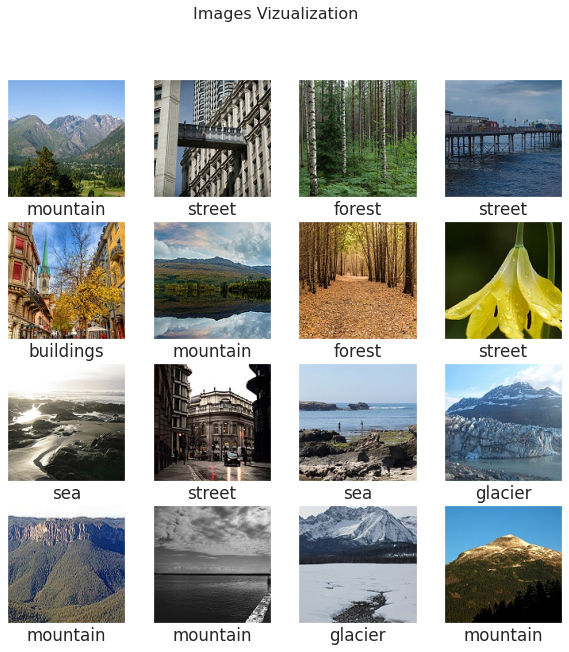

In [125]:
# Retutns 16 images from the prediction dataset
pred_imgs = get16PredicRandom()

# Returns the probability of beeing in each class for each image
predictions = mlp_tunned_model.predict(pred_imgs)
# Picking the highest probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

imgVisualization(pred_imgs, pred_labels)

### Confusion Matrix

<AxesSubplot:>

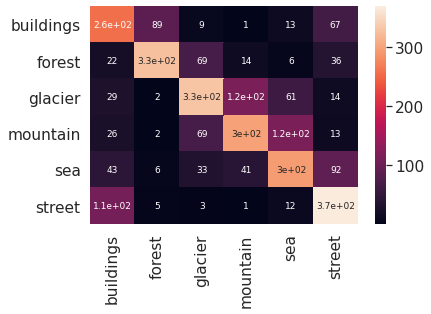

In [126]:
#Confution Matrix and Classification Report
Y_pred = mlp_tunned_model.predict_generator(test_it, 3000 // BATCH_SIZE + 1)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_it.classes, y_pred)
df_cm = pd.DataFrame(cm, label_enum, label_enum)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size